In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

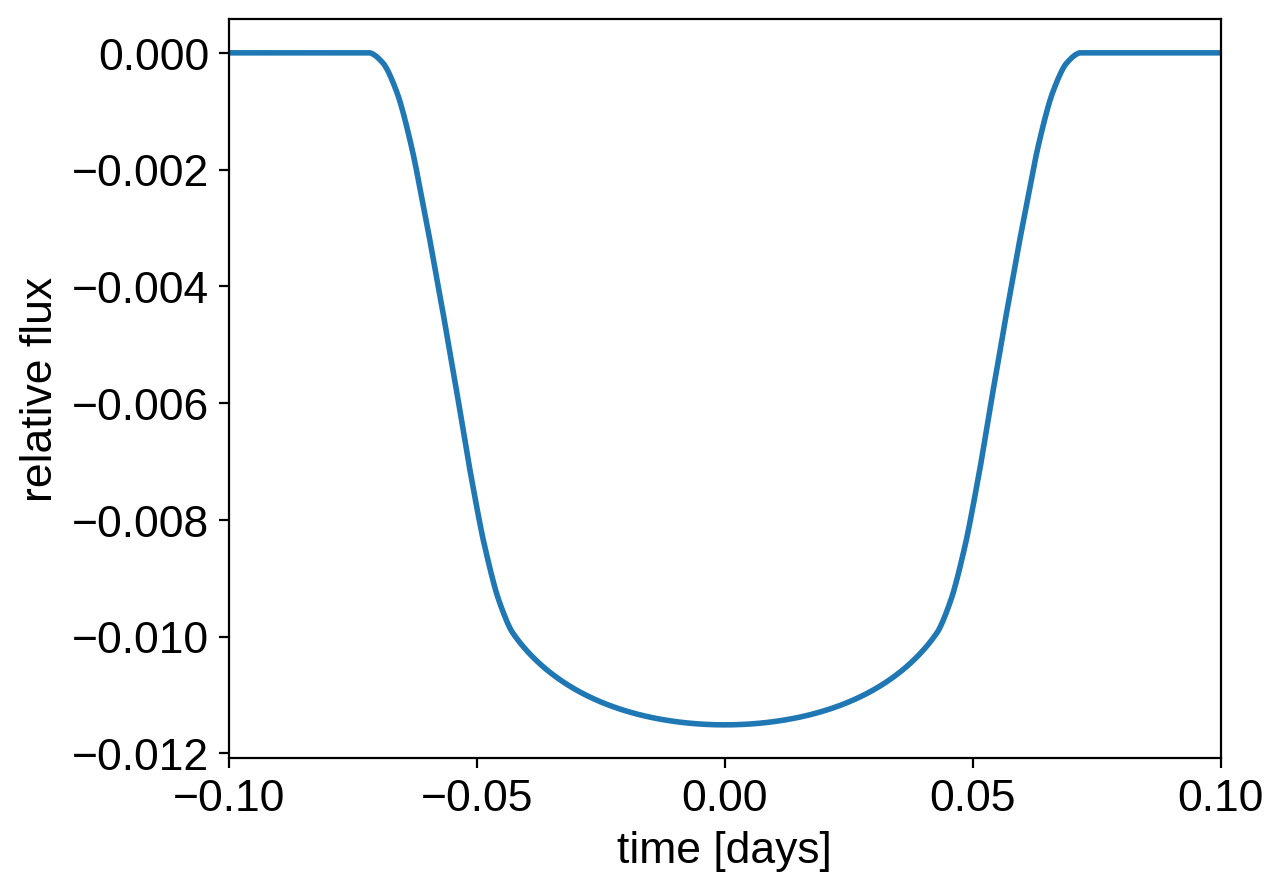

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=0.1, t=t, texp=0.02)
    .eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [4]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [5]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform(
        "r", lower=0.01, upper=0.1, shape=2, testval=np.array([0.04, 0.06])
    )
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=2, testval=np.random.rand(2)
    )

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # In this line, we simulate the dataset that we will fit
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [b, r, u, logP, t0, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.478798e+04]

1it [00:00, 233.91it/s, logp=2.478798e+04]

2it [00:00, 339.40it/s, logp=-4.973052e+09]

3it [00:00, 407.91it/s, logp=2.478859e+04] 

4it [00:00, 447.64it/s, logp=2.478913e+04]

5it [00:00, 475.02it/s, logp=2.478977e+04]

6it [00:00, 496.26it/s, logp=2.479074e+04]

7it [00:00, 512.48it/s, logp=2.478483e+04]

8it [00:00, 529.80it/s, logp=2.479082e+04]

9it [00:00, 534.13it/s, logp=2.479098e+04]

10it [00:00, 546.70it/s, logp=2.479151e+04]

11it [00:00, 551.84it/s, logp=2.479065e+04]

12it [00:00, 558.09it/s, logp=2.479174e+04]

13it [00:00, 565.58it/s, logp=2.479145e+04]

14it [00:00, 574.31it/s, logp=2.479182e+04]

15it [00:00, 576.20it/s, logp=2.479195e+04]

16it [00:00, 581.57it/s, logp=2.479239e+04]

17it [00:00, 584.84it/s, logp=2.479094e+04]

18it [00:00, 588.69it/s, logp=2.479253e+04]

19it [00:00, 586.59it/s, logp=2.479279e+04]

20it [00:00, 589.34it/s, logp=2.479323e+04]

21it [00:00, 591.82it/s, logp=2.479351e+04]

22it [00:00, 592.08it/s, logp=2.479354e+04]

23it [00:00, 594.20it/s, logp=2.479354e+04]

24it [00:00, 595.27it/s, logp=2.479354e+04]

25it [00:00, 597.84it/s, logp=2.479354e+04]

26it [00:00, 598.49it/s, logp=2.479354e+04]

27it [00:00, 599.30it/s, logp=2.479354e+04]

28it [00:00, 596.72it/s, logp=2.479354e+04]

29it [00:00, 597.35it/s, logp=2.479354e+04]

30it [00:00, 597.98it/s, logp=2.479354e+04]

31it [00:00, 599.91it/s, logp=2.479354e+04]

32it [00:00, 601.90it/s, logp=2.479354e+04]

33it [00:00, 603.73it/s, logp=2.479354e+04]

34it [00:00, 606.54it/s, logp=2.479354e+04]

35it [00:00, 608.86it/s, logp=2.479354e+04]

36it [00:00, 611.91it/s, logp=2.479354e+04]

37it [00:00, 611.38it/s, logp=2.479354e+04]

38it [00:00, 613.51it/s, logp=2.479354e+04]

39it [00:00, 613.36it/s, logp=2.479354e+04]

40it [00:00, 614.83it/s, logp=2.479354e+04]

41it [00:00, 615.76it/s, logp=2.479354e+04]

42it [00:00, 616.49it/s, logp=2.479354e+04]

43it [00:00, 616.66it/s, logp=2.479354e+04]

44it [00:00, 618.24it/s, logp=2.479354e+04]

45it [00:00, 620.05it/s, logp=2.479354e+04]

46it [00:00, 620.26it/s, logp=2.479354e+04]

47it [00:00, 621.67it/s, logp=2.479354e+04]

48it [00:00, 622.80it/s, logp=2.479354e+04]

49it [00:00, 624.09it/s, logp=2.479354e+04]

50it [00:00, 623.08it/s, logp=2.479354e+04]

51it [00:00, 624.81it/s, logp=2.479354e+04]

52it [00:00, 626.64it/s, logp=2.479354e+04]

53it [00:00, 626.41it/s, logp=2.479354e+04]

54it [00:00, 627.74it/s, logp=2.479354e+04]

55it [00:00, 628.60it/s, logp=2.479354e+04]

56it [00:00, 630.11it/s, logp=2.479354e+04]

57it [00:00, 630.11it/s, logp=2.479354e+04]

58it [00:00, 630.94it/s, logp=2.479354e+04]

59it [00:00, 631.90it/s, logp=2.479354e+04]

60it [00:00, 632.24it/s, logp=2.479354e+04]

61it [00:00, 632.50it/s, logp=2.479354e+04]

62it [00:00, 633.74it/s, logp=2.479354e+04]

63it [00:00, 634.29it/s, logp=2.479354e+04]

64it [00:00, 634.89it/s, logp=2.479354e+04]

65it [00:00, 641.30it/s, logp=2.479354e+04]

65it [00:00, 641.30it/s, logp=2.479354e+04]

66it [00:00, 641.30it/s, logp=2.479354e+04]

67it [00:00, 641.30it/s, logp=2.479354e+04]

68it [00:00, 641.30it/s, logp=2.479354e+04]

69it [00:00, 641.30it/s, logp=2.479354e+04]

70it [00:00, 641.30it/s, logp=2.479354e+04]

71it [00:00, 641.30it/s, logp=2.479354e+04]

72it [00:00, 641.30it/s, logp=2.479354e+04]

73it [00:00, 641.30it/s, logp=2.479354e+04]

74it [00:00, 641.30it/s, logp=2.479354e+04]

75it [00:00, 641.30it/s, logp=2.479354e+04]

76it [00:00, 641.30it/s, logp=2.479354e+04]

77it [00:00, 641.30it/s, logp=2.479354e+04]

78it [00:00, 641.30it/s, logp=2.479354e+04]

79it [00:00, 641.30it/s, logp=2.479354e+04]

80it [00:00, 641.30it/s, logp=2.479354e+04]

81it [00:00, 641.30it/s, logp=2.479354e+04]

82it [00:00, 641.30it/s, logp=2.479354e+04]

83it [00:00, 641.30it/s, logp=2.479354e+04]

84it [00:00, 641.30it/s, logp=2.479354e+04]

85it [00:00, 641.30it/s, logp=2.479354e+04]

86it [00:00, 641.30it/s, logp=2.479354e+04]

87it [00:00, 641.30it/s, logp=2.479354e+04]

88it [00:00, 641.30it/s, logp=2.479354e+04]

89it [00:00, 641.30it/s, logp=2.479354e+04]

90it [00:00, 641.30it/s, logp=2.479354e+04]

91it [00:00, 641.30it/s, logp=2.479354e+04]

92it [00:00, 641.30it/s, logp=2.479354e+04]

93it [00:00, 641.30it/s, logp=2.479354e+04]

94it [00:00, 641.30it/s, logp=2.479354e+04]

95it [00:00, 641.30it/s, logp=2.479354e+04]

96it [00:00, 641.30it/s, logp=2.479354e+04]

97it [00:00, 641.30it/s, logp=2.479354e+04]

98it [00:00, 641.30it/s, logp=2.479354e+04]

99it [00:00, 641.30it/s, logp=2.479354e+04]

100it [00:00, 124.35it/s, logp=2.479354e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 24787.977771807487 -> 24793.53942561119


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

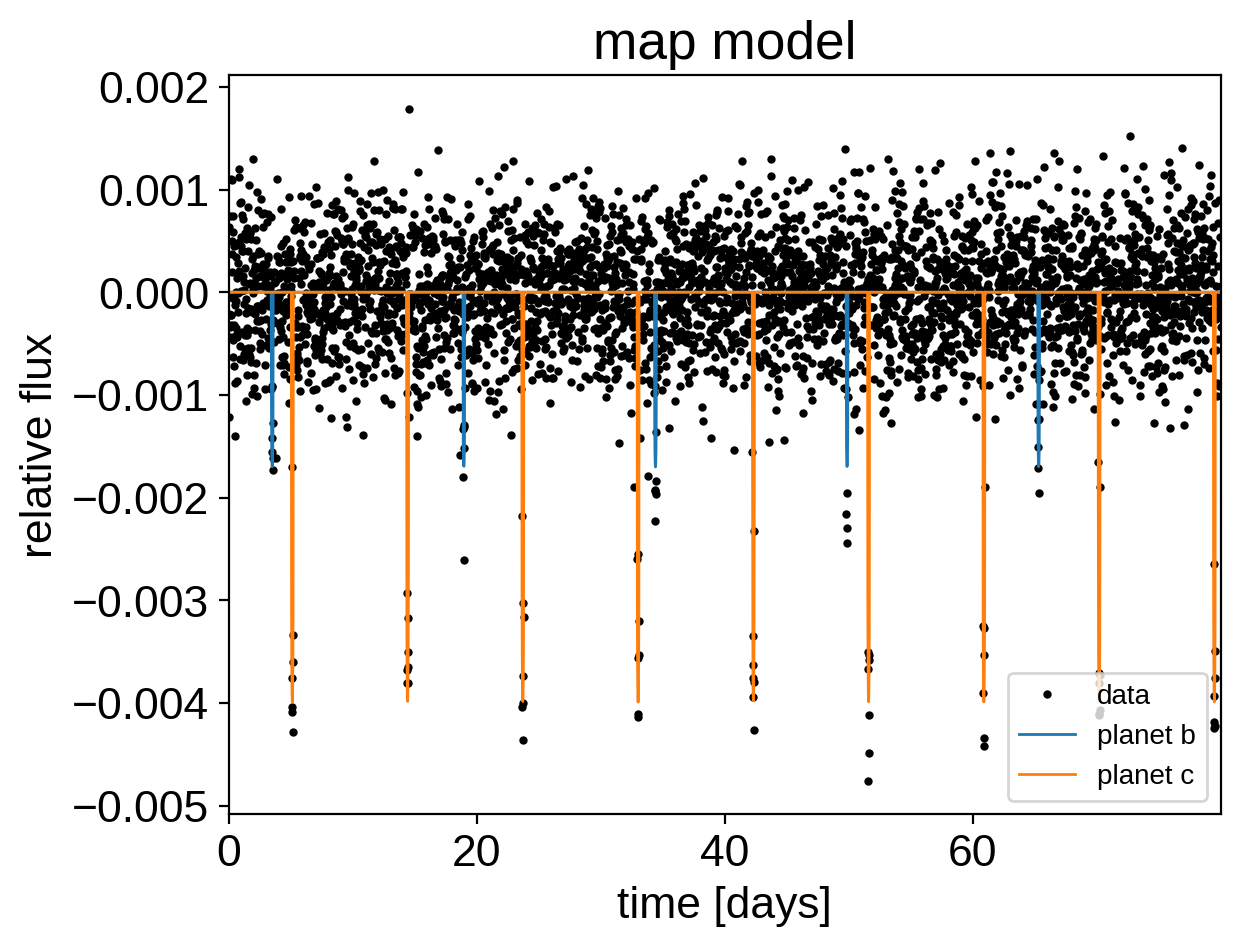

In [6]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use :func:`exoplanet.get_dense_nuts_step`.

In [7]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=3000,
        draws=3000,
        start=map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [b, r, u, logP, t0, mean]


Sampling 2 chains, 0 divergences:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 11/12000 [00:00<03:35, 55.61draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 13/12000 [00:00<07:50, 25.46draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 15/12000 [00:00<10:50, 18.43draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 17/12000 [00:00<13:05, 15.25draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 19/12000 [00:00<14:44, 13.54draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 21/12000 [00:01<15:42, 12.71draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 23/12000 [00:01<16:27, 12.13draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 25/12000 [00:01<16:51, 11.84draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 27/12000 [00:01<17:23, 11.48draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 29/12000 [00:01<17:28, 11.42draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 31/12000 [00:02<17:35, 11.34draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 34/12000 [00:02<15:57, 12.50draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 36/12000 [00:02<16:27, 12.11draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 38/12000 [00:02<16:51, 11.83draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 40/12000 [00:02<17:41, 11.26draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 42/12000 [00:02<17:38, 11.30draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 44/12000 [00:03<17:38, 11.29draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 46/12000 [00:03<18:07, 10.99draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 48/12000 [00:03<18:08, 10.98draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 50/12000 [00:03<18:19, 10.86draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 52/12000 [00:03<18:24, 10.82draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 54/12000 [00:04<18:21, 10.85draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 56/12000 [00:04<18:14, 10.91draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 58/12000 [00:04<18:07, 10.98draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 60/12000 [00:04<18:07, 10.98draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 62/12000 [00:04<18:04, 11.01draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 64/12000 [00:04<17:58, 11.07draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 66/12000 [00:05<17:55, 11.10draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 68/12000 [00:05<17:57, 11.07draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 70/12000 [00:05<17:53, 11.11draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 72/12000 [00:05<17:53, 11.11draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 74/12000 [00:05<18:24, 10.80draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 76/12000 [00:06<18:13, 10.91draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 78/12000 [00:06<18:09, 10.94draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 80/12000 [00:06<18:07, 10.96draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 82/12000 [00:06<18:00, 11.03draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 84/12000 [00:06<18:01, 11.02draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 86/12000 [00:06<17:56, 11.07draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 88/12000 [00:07<17:53, 11.09draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 90/12000 [00:07<17:59, 11.03draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 92/12000 [00:07<17:58, 11.04draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 94/12000 [00:07<17:53, 11.09draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 96/12000 [00:07<17:51, 11.11draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 98/12000 [00:08<18:02, 10.99draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 100/12000 [00:08<17:54, 11.07draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 102/12000 [00:08<17:54, 11.07draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 104/12000 [00:08<17:54, 11.07draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 106/12000 [00:08<17:47, 11.14draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 108/12000 [00:08<18:04, 10.97draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 110/12000 [00:09<17:59, 11.01draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 112/12000 [00:09<17:49, 11.11draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 114/12000 [00:09<18:00, 11.00draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 116/12000 [00:09<17:50, 11.11draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 118/12000 [00:09<17:47, 11.13draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 120/12000 [00:09<17:43, 11.17draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 122/12000 [00:10<17:48, 11.11draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 124/12000 [00:10<17:55, 11.04draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 126/12000 [00:10<17:49, 11.10draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 129/12000 [00:10<16:08, 12.26draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 131/12000 [00:10<16:37, 11.90draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 133/12000 [00:11<16:53, 11.71draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 135/12000 [00:11<17:04, 11.58draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 137/12000 [00:11<17:23, 11.37draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 139/12000 [00:11<17:25, 11.35draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 141/12000 [00:11<17:37, 11.21draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 143/12000 [00:11<18:05, 10.93draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 145/12000 [00:12<18:01, 10.96draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 147/12000 [00:12<17:53, 11.04draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 149/12000 [00:12<17:53, 11.04draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 151/12000 [00:12<17:48, 11.09draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 153/12000 [00:12<17:44, 11.13draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 155/12000 [00:13<17:43, 11.14draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 157/12000 [00:13<15:49, 12.48draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 159/12000 [00:13<16:16, 12.12draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 161/12000 [00:13<16:38, 11.86draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 163/12000 [00:13<16:46, 11.76draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 165/12000 [00:13<17:08, 11.51draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 167/12000 [00:14<17:30, 11.26draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 169/12000 [00:14<17:28, 11.28draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 171/12000 [00:14<17:29, 11.27draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 173/12000 [00:14<17:38, 11.18draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 175/12000 [00:14<17:34, 11.21draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 177/12000 [00:14<18:11, 10.84draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 179/12000 [00:15<17:59, 10.95draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 181/12000 [00:15<17:48, 11.06draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 183/12000 [00:15<17:47, 11.07draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 185/12000 [00:15<17:52, 11.02draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 187/12000 [00:15<17:45, 11.09draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 189/12000 [00:16<17:50, 11.03draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 191/12000 [00:16<17:55, 10.98draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 193/12000 [00:16<17:47, 11.06draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 195/12000 [00:16<18:20, 10.73draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 197/12000 [00:16<18:02, 10.91draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 199/12000 [00:16<17:49, 11.03draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 201/12000 [00:17<17:46, 11.07draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 203/12000 [00:17<17:47, 11.05draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 205/12000 [00:17<17:49, 11.02draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 207/12000 [00:17<17:46, 11.06draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 209/12000 [00:17<17:41, 11.10draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 211/12000 [00:18<18:11, 10.80draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 213/12000 [00:18<17:58, 10.93draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 215/12000 [00:18<17:48, 11.03draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 217/12000 [00:18<17:57, 10.94draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 219/12000 [00:18<17:48, 11.02draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 221/12000 [00:18<17:46, 11.05draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 223/12000 [00:19<17:45, 11.06draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 225/12000 [00:19<17:44, 11.06draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 227/12000 [00:19<17:38, 11.13draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 229/12000 [00:19<17:47, 11.02draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 231/12000 [00:19<17:46, 11.04draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 233/12000 [00:20<17:50, 10.99draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 235/12000 [00:20<17:51, 10.98draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 237/12000 [00:20<17:47, 11.02draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 239/12000 [00:20<17:45, 11.03draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 241/12000 [00:20<17:42, 11.06draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 243/12000 [00:20<17:41, 11.08draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 245/12000 [00:21<17:46, 11.02draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 247/12000 [00:21<17:39, 11.10draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 249/12000 [00:21<17:34, 11.15draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 251/12000 [00:21<17:33, 11.16draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 253/12000 [00:21<17:27, 11.21draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 255/12000 [00:22<17:24, 11.24draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 257/12000 [00:22<17:26, 11.22draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 259/12000 [00:22<17:24, 11.25draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 261/12000 [00:22<17:22, 11.26draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 263/12000 [00:22<17:31, 11.16draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 265/12000 [00:22<17:26, 11.21draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 267/12000 [00:23<17:25, 11.22draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 269/12000 [00:23<17:28, 11.19draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 271/12000 [00:23<17:25, 11.22draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 273/12000 [00:23<17:27, 11.20draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 275/12000 [00:23<17:40, 11.05draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 277/12000 [00:24<17:37, 11.09draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 279/12000 [00:24<17:46, 10.99draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 281/12000 [00:24<17:37, 11.08draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 283/12000 [00:24<17:32, 11.13draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 285/12000 [00:24<17:29, 11.16draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 288/12000 [00:24<17:01, 11.47draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 291/12000 [00:25<15:56, 12.24draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 293/12000 [00:25<16:18, 11.96draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 296/12000 [00:25<14:59, 13.01draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 298/12000 [00:25<14:22, 13.57draws/s]

Sampling 2 chains, 0 divergences:   2%|▎         | 300/12000 [00:25<15:35, 12.51draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 303/12000 [00:25<13:07, 14.85draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 305/12000 [00:26<13:43, 14.20draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 307/12000 [00:26<14:57, 13.03draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 309/12000 [00:26<13:49, 14.10draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 311/12000 [00:26<14:50, 13.13draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 314/12000 [00:26<12:31, 15.54draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 322/12000 [00:26<09:30, 20.47draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 330/12000 [00:26<07:25, 26.20draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 335/12000 [00:27<06:27, 30.08draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 341/12000 [00:27<05:30, 35.33draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 353/12000 [00:27<04:21, 44.51draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 364/12000 [00:27<03:36, 53.73draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 376/12000 [00:27<03:02, 63.59draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 390/12000 [00:27<02:33, 75.61draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 410/12000 [00:27<02:05, 92.57draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 424/12000 [00:27<01:59, 97.19draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 440/12000 [00:27<01:46, 108.16draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 459/12000 [00:28<01:34, 122.48draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 476/12000 [00:28<01:27, 131.89draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 496/12000 [00:28<01:19, 144.50draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 514/12000 [00:28<01:16, 149.28draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 533/12000 [00:28<01:12, 158.45draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 550/12000 [00:28<01:11, 159.75draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 571/12000 [00:28<01:07, 168.50draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 589/12000 [00:28<01:07, 168.46draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 607/12000 [00:28<01:08, 167.32draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 627/12000 [00:28<01:04, 175.52draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 647/12000 [00:29<01:03, 179.43draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 667/12000 [00:29<01:01, 184.35draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 689/12000 [00:29<00:59, 190.17draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 709/12000 [00:29<01:02, 181.55draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 728/12000 [00:29<01:10, 160.75draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 747/12000 [00:29<01:08, 163.99draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 767/12000 [00:29<01:05, 171.05draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 787/12000 [00:29<01:03, 177.20draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 807/12000 [00:29<01:01, 183.24draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 831/12000 [00:30<00:56, 196.81draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 852/12000 [00:30<00:58, 191.17draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 872/12000 [00:30<01:02, 177.25draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 891/12000 [00:30<01:03, 175.05draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 909/12000 [00:30<01:03, 174.33draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 927/12000 [00:30<01:08, 162.28draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 944/12000 [00:30<01:08, 160.75draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 962/12000 [00:30<01:06, 166.07draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 982/12000 [00:30<01:03, 173.18draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1000/12000 [00:31<01:05, 169.02draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1020/12000 [00:31<01:02, 175.86draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1039/12000 [00:31<01:01, 178.93draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1058/12000 [00:31<01:01, 177.88draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1076/12000 [00:31<01:02, 175.58draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1094/12000 [00:31<01:04, 168.37draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1111/12000 [00:31<01:06, 164.73draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1128/12000 [00:31<01:11, 152.37draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1144/12000 [00:31<01:10, 154.30draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1162/12000 [00:32<01:08, 158.80draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1182/12000 [00:32<01:05, 165.96draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1205/12000 [00:32<00:59, 180.04draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1224/12000 [00:32<00:59, 180.04draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1243/12000 [00:32<01:00, 177.37draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1261/12000 [00:32<01:01, 174.54draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1279/12000 [00:32<01:02, 172.15draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1297/12000 [00:32<01:04, 166.53draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1317/12000 [00:32<01:01, 172.55draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1339/12000 [00:33<00:58, 182.62draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1358/12000 [00:33<00:59, 178.80draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1377/12000 [00:33<00:58, 180.19draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1396/12000 [00:33<01:01, 172.91draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1415/12000 [00:33<00:59, 177.30draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1433/12000 [00:33<01:01, 172.93draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1451/12000 [00:33<01:00, 173.74draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1469/12000 [00:33<01:01, 170.23draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1487/12000 [00:33<01:02, 167.01draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1508/12000 [00:34<00:59, 177.55draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1526/12000 [00:34<01:00, 171.75draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1544/12000 [00:34<01:01, 169.42draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1562/12000 [00:34<01:03, 164.04draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1581/12000 [00:34<01:01, 170.50draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1599/12000 [00:34<01:00, 172.84draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 1618/12000 [00:34<01:00, 172.52draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 1637/12000 [00:34<00:58, 176.56draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1656/12000 [00:34<00:57, 180.37draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1676/12000 [00:34<00:56, 183.12draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1696/12000 [00:35<00:55, 185.13draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1716/12000 [00:35<00:55, 184.99draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 1735/12000 [00:35<00:58, 175.28draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1754/12000 [00:35<00:57, 176.70draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1773/12000 [00:35<00:57, 178.79draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 1792/12000 [00:35<00:56, 180.96draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1811/12000 [00:35<00:56, 179.93draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1830/12000 [00:35<00:56, 179.49draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 1850/12000 [00:35<00:55, 182.10draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1869/12000 [00:36<00:56, 177.74draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1887/12000 [00:36<01:02, 163.09draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1904/12000 [00:36<01:03, 159.25draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1922/12000 [00:36<01:01, 164.37draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 1941/12000 [00:36<00:58, 171.25draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 1959/12000 [00:36<00:57, 173.63draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 1977/12000 [00:36<00:57, 174.00draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 1995/12000 [00:36<00:58, 170.28draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2013/12000 [00:36<00:57, 172.53draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2032/12000 [00:37<00:57, 174.51draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2050/12000 [00:37<00:57, 173.40draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2068/12000 [00:37<00:57, 172.26draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2087/12000 [00:37<00:57, 172.32draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2107/12000 [00:37<00:55, 177.22draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2125/12000 [00:37<00:56, 176.31draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2143/12000 [00:37<00:55, 177.27draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2162/12000 [00:37<00:54, 179.74draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2181/12000 [00:37<00:54, 178.68draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2199/12000 [00:37<00:54, 178.99draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2218/12000 [00:38<00:54, 178.90draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 2238/12000 [00:38<00:53, 182.15draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2257/12000 [00:38<00:55, 176.12draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2275/12000 [00:38<00:56, 171.94draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2293/12000 [00:38<00:55, 174.09draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2311/12000 [00:38<00:56, 170.92draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 2329/12000 [00:38<00:59, 163.31draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 2346/12000 [00:38<00:58, 164.04draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 2366/12000 [00:38<00:56, 170.95draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 2384/12000 [00:39<00:56, 171.39draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 2402/12000 [00:39<00:56, 169.09draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 2419/12000 [00:39<00:57, 165.29draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 2438/12000 [00:39<00:56, 170.46draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 2458/12000 [00:39<00:54, 175.96draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2477/12000 [00:39<00:53, 177.15draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2496/12000 [00:39<00:53, 178.73draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2514/12000 [00:39<00:54, 173.28draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 2532/12000 [00:39<00:56, 168.85draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 2552/12000 [00:40<00:54, 174.40draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 2570/12000 [00:40<00:54, 173.62draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2588/12000 [00:40<00:54, 172.15draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2606/12000 [00:40<00:55, 169.79draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2624/12000 [00:40<00:55, 168.00draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2641/12000 [00:40<00:57, 161.76draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2658/12000 [00:40<00:57, 163.63draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2675/12000 [00:40<00:57, 163.39draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 2693/12000 [00:40<00:56, 164.97draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2711/12000 [00:40<00:55, 166.35draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2730/12000 [00:41<00:53, 172.61draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2749/12000 [00:41<00:53, 173.69draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2767/12000 [00:41<00:53, 171.38draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2785/12000 [00:41<00:53, 170.89draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 2803/12000 [00:41<00:53, 172.95draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 2821/12000 [00:41<00:53, 170.80draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 2840/12000 [00:41<00:53, 171.58draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2859/12000 [00:41<00:52, 172.92draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2877/12000 [00:41<00:53, 171.60draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2895/12000 [00:42<00:52, 173.16draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2913/12000 [00:42<00:52, 173.22draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 2931/12000 [00:42<00:52, 174.22draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 2949/12000 [00:42<00:53, 169.36draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 2966/12000 [00:42<00:55, 163.71draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 2983/12000 [00:42<00:56, 160.01draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 3002/12000 [00:42<00:54, 166.36draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 3019/12000 [00:42<00:55, 162.43draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 3036/12000 [00:42<00:55, 160.59draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 3053/12000 [00:43<00:56, 159.34draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3070/12000 [00:43<00:55, 162.18draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3089/12000 [00:43<00:53, 167.81draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3107/12000 [00:43<00:52, 170.71draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3125/12000 [00:43<00:51, 171.27draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 3144/12000 [00:43<00:50, 175.80draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 3163/12000 [00:43<00:49, 178.36draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3181/12000 [00:43<00:50, 174.34draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3199/12000 [00:43<00:51, 170.08draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3217/12000 [00:43<00:51, 169.26draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3234/12000 [00:44<00:53, 162.35draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3252/12000 [00:44<00:53, 164.38draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3271/12000 [00:44<00:51, 170.38draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 3289/12000 [00:44<00:51, 170.44draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3309/12000 [00:44<00:49, 174.89draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3328/12000 [00:44<00:49, 174.78draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3346/12000 [00:44<00:50, 172.99draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3365/12000 [00:44<00:49, 174.06draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3383/12000 [00:44<00:50, 172.09draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 3401/12000 [00:45<00:50, 170.87draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 3422/12000 [00:45<00:47, 179.17draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 3441/12000 [00:45<00:53, 158.98draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3458/12000 [00:45<00:54, 157.10draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3475/12000 [00:45<00:55, 152.66draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3494/12000 [00:45<00:53, 160.09draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3512/12000 [00:45<00:51, 164.89draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 3529/12000 [00:45<00:51, 165.51draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 3546/12000 [00:45<00:50, 166.43draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 3566/12000 [00:46<00:49, 171.15draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 3585/12000 [00:46<00:48, 171.76draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 3604/12000 [00:46<00:48, 173.07draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 3622/12000 [00:46<00:49, 170.30draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 3641/12000 [00:46<00:47, 175.09draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 3659/12000 [00:46<00:47, 176.42draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3679/12000 [00:46<00:46, 178.08draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3697/12000 [00:46<00:47, 175.61draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3717/12000 [00:46<00:46, 178.81draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 3735/12000 [00:46<00:47, 175.57draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 3753/12000 [00:47<00:47, 172.76draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 3771/12000 [00:47<00:48, 168.02draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3788/12000 [00:47<00:50, 162.30draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3808/12000 [00:47<00:48, 168.57draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3829/12000 [00:47<00:46, 176.42draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3847/12000 [00:47<00:46, 177.02draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3866/12000 [00:47<00:45, 180.43draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 3886/12000 [00:47<00:44, 183.26draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3906/12000 [00:47<00:43, 185.79draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3926/12000 [00:48<00:43, 186.39draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3946/12000 [00:48<00:43, 186.26draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3966/12000 [00:48<00:43, 185.70draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 3985/12000 [00:48<00:44, 180.00draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 4004/12000 [00:48<00:45, 174.80draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 4022/12000 [00:48<00:48, 165.49draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 4040/12000 [00:48<00:47, 167.57draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4058/12000 [00:48<00:46, 169.88draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4076/12000 [00:48<00:46, 169.70draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4094/12000 [00:49<00:45, 172.55draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4113/12000 [00:49<00:44, 175.45draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 4131/12000 [00:49<00:45, 172.81draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 4151/12000 [00:49<00:44, 175.82draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 4170/12000 [00:49<00:43, 179.37draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 4188/12000 [00:49<00:44, 174.43draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 4206/12000 [00:49<00:45, 172.87draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 4224/12000 [00:49<00:45, 171.99draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 4243/12000 [00:49<00:43, 176.82draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4261/12000 [00:49<00:44, 174.39draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4279/12000 [00:50<00:45, 170.30draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4297/12000 [00:50<00:44, 172.48draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4316/12000 [00:50<00:43, 175.76draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 4334/12000 [00:50<00:44, 172.42draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 4352/12000 [00:50<00:44, 171.58draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 4370/12000 [00:50<00:44, 169.83draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4388/12000 [00:50<00:44, 172.75draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4406/12000 [00:50<00:45, 167.11draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4427/12000 [00:50<00:42, 176.67draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4447/12000 [00:51<00:41, 181.12draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4466/12000 [00:51<00:42, 177.66draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 4486/12000 [00:51<00:41, 182.74draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4505/12000 [00:51<00:40, 184.64draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4524/12000 [00:51<00:41, 180.64draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4543/12000 [00:51<00:42, 173.71draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4561/12000 [00:51<00:42, 174.47draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4579/12000 [00:51<00:42, 173.19draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4597/12000 [00:51<00:42, 173.04draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 4616/12000 [00:52<00:42, 175.57draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 4636/12000 [00:52<00:40, 181.44draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4656/12000 [00:52<00:39, 186.17draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4675/12000 [00:52<00:40, 180.78draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4695/12000 [00:52<00:39, 185.40draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4714/12000 [00:52<00:39, 185.31draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 4734/12000 [00:52<00:38, 189.44draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 4754/12000 [00:52<00:39, 182.63draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 4773/12000 [00:52<00:39, 181.57draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 4794/12000 [00:52<00:38, 184.96draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 4815/12000 [00:53<00:37, 191.36draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 4835/12000 [00:53<00:37, 193.09draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 4857/12000 [00:53<00:35, 199.06draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4878/12000 [00:53<00:37, 192.41draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4898/12000 [00:53<00:38, 183.78draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4917/12000 [00:53<00:39, 179.61draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 4936/12000 [00:53<00:40, 176.17draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 4954/12000 [00:53<00:40, 174.72draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 4972/12000 [00:53<00:40, 173.49draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 4990/12000 [00:54<00:40, 172.97draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5008/12000 [00:54<00:40, 174.32draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5027/12000 [00:54<00:39, 176.15draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5045/12000 [00:54<00:40, 172.84draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5065/12000 [00:54<00:39, 175.02draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 5083/12000 [00:54<00:39, 173.93draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5101/12000 [00:54<00:40, 172.06draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5119/12000 [00:54<00:40, 170.55draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5138/12000 [00:54<00:39, 175.68draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5157/12000 [00:54<00:38, 179.66draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5176/12000 [00:55<00:38, 179.55draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5194/12000 [00:55<00:38, 175.72draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 5212/12000 [00:55<00:40, 169.32draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 5230/12000 [00:55<00:39, 171.45draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 5249/12000 [00:55<00:38, 173.40draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5268/12000 [00:55<00:37, 177.56draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5286/12000 [00:55<00:38, 176.59draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5304/12000 [00:55<00:39, 171.43draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 5322/12000 [00:55<00:38, 172.85draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 5343/12000 [00:56<00:36, 182.08draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 5362/12000 [00:56<00:36, 183.75draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 5381/12000 [00:56<00:36, 182.93draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 5403/12000 [00:56<00:34, 189.07draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 5423/12000 [00:56<00:34, 188.80draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 5442/12000 [00:56<00:36, 181.45draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5461/12000 [00:56<00:38, 171.55draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5479/12000 [00:56<00:39, 165.70draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5497/12000 [00:56<00:39, 165.98draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5516/12000 [00:57<00:37, 170.99draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 5537/12000 [00:57<00:36, 178.52draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 5557/12000 [00:57<00:35, 182.48draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5583/12000 [00:57<00:32, 200.28draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5606/12000 [00:57<00:30, 207.44draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5628/12000 [00:57<00:31, 203.96draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5649/12000 [00:57<00:32, 195.47draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5669/12000 [00:57<00:36, 172.93draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 5688/12000 [00:57<00:39, 160.84draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5705/12000 [00:58<00:39, 160.51draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5722/12000 [00:58<00:39, 159.64draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5742/12000 [00:58<00:37, 168.33draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5760/12000 [00:58<00:40, 155.29draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5776/12000 [00:58<00:42, 145.68draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5792/12000 [00:58<00:41, 148.51draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 5809/12000 [00:58<00:40, 151.69draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 5827/12000 [00:58<00:38, 158.63draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 5844/12000 [00:58<00:38, 159.98draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5863/12000 [00:59<00:36, 167.54draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5881/12000 [00:59<00:35, 170.33draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5899/12000 [00:59<00:35, 169.73draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5917/12000 [00:59<00:37, 163.90draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 5935/12000 [00:59<00:36, 168.02draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 5955/12000 [00:59<00:35, 172.38draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 5973/12000 [00:59<00:35, 171.59draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 5992/12000 [00:59<00:34, 175.22draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 6012/12000 [00:59<00:33, 180.27draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 6031/12000 [01:00<00:32, 182.67draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 6050/12000 [01:00<00:33, 178.97draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6068/12000 [01:00<00:34, 174.05draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6087/12000 [01:00<00:33, 177.59draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6106/12000 [01:00<00:32, 178.85draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6124/12000 [01:00<00:32, 178.26draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 6142/12000 [01:00<00:32, 178.74draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 6160/12000 [01:00<00:33, 176.93draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 6178/12000 [01:00<00:35, 165.14draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6195/12000 [01:00<00:35, 165.06draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6212/12000 [01:01<00:34, 165.82draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6231/12000 [01:01<00:34, 169.26draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6249/12000 [01:01<00:33, 170.34draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6269/12000 [01:01<00:32, 175.28draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 6288/12000 [01:01<00:31, 179.05draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6309/12000 [01:01<00:30, 184.22draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6328/12000 [01:01<00:31, 180.97draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6347/12000 [01:01<00:32, 175.97draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6365/12000 [01:01<00:32, 174.10draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6385/12000 [01:02<00:31, 178.42draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 6403/12000 [01:02<00:31, 175.93draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 6423/12000 [01:02<00:30, 180.99draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 6442/12000 [01:02<00:30, 182.39draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6461/12000 [01:02<00:30, 179.74draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6481/12000 [01:02<00:30, 180.86draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6500/12000 [01:02<00:30, 181.00draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6519/12000 [01:02<00:30, 181.31draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 6538/12000 [01:02<00:30, 181.53draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 6557/12000 [01:02<00:29, 183.51draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 6576/12000 [01:03<00:30, 180.16draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 6595/12000 [01:03<00:29, 182.52draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 6614/12000 [01:03<00:29, 183.43draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 6633/12000 [01:03<00:29, 180.74draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 6653/12000 [01:03<00:29, 183.48draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6672/12000 [01:03<00:29, 179.33draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6690/12000 [01:03<00:29, 177.07draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6708/12000 [01:03<00:30, 175.30draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6726/12000 [01:03<00:31, 169.90draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 6744/12000 [01:04<00:30, 171.38draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 6765/12000 [01:04<00:28, 180.93draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6784/12000 [01:04<00:29, 179.63draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6803/12000 [01:04<00:29, 178.31draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6821/12000 [01:04<00:29, 177.71draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6839/12000 [01:04<00:29, 176.01draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6857/12000 [01:04<00:29, 175.27draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6875/12000 [01:04<00:29, 173.74draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 6893/12000 [01:04<00:29, 174.27draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6912/12000 [01:04<00:28, 175.84draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6932/12000 [01:05<00:28, 179.94draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6951/12000 [01:05<00:28, 175.65draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6969/12000 [01:05<00:28, 176.44draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 6987/12000 [01:05<00:29, 168.77draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 7007/12000 [01:05<00:28, 175.64draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 7025/12000 [01:05<00:28, 173.95draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 7043/12000 [01:05<00:28, 174.18draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7061/12000 [01:05<00:28, 171.92draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7079/12000 [01:05<00:28, 169.89draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7097/12000 [01:06<00:28, 171.25draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7115/12000 [01:06<00:28, 169.74draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 7136/12000 [01:06<00:27, 177.33draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 7154/12000 [01:06<00:27, 176.36draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 7172/12000 [01:06<00:27, 177.27draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 7191/12000 [01:06<00:27, 176.97draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 7210/12000 [01:06<00:26, 178.57draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 7228/12000 [01:06<00:27, 176.48draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 7246/12000 [01:06<00:27, 173.90draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7264/12000 [01:07<00:28, 167.72draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7281/12000 [01:07<00:28, 168.31draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7300/12000 [01:07<00:27, 171.25draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7318/12000 [01:07<00:27, 172.27draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 7336/12000 [01:07<00:27, 172.62draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 7354/12000 [01:07<00:26, 172.85draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 7373/12000 [01:07<00:26, 175.19draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7391/12000 [01:07<00:26, 174.63draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7410/12000 [01:07<00:25, 176.60draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7428/12000 [01:07<00:25, 175.99draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7447/12000 [01:08<00:25, 179.46draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7465/12000 [01:08<00:25, 176.14draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 7483/12000 [01:08<00:25, 175.67draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7501/12000 [01:08<00:25, 176.29draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7519/12000 [01:08<00:25, 176.60draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7537/12000 [01:08<00:25, 173.91draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7556/12000 [01:08<00:24, 177.95draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7576/12000 [01:08<00:24, 180.76draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7595/12000 [01:08<00:24, 180.64draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 7614/12000 [01:08<00:24, 180.95draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 7633/12000 [01:09<00:24, 181.16draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7652/12000 [01:09<00:23, 182.75draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7671/12000 [01:09<00:23, 180.56draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7691/12000 [01:09<00:23, 183.31draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7711/12000 [01:09<00:23, 186.20draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 7730/12000 [01:09<00:23, 182.22draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 7749/12000 [01:09<00:23, 183.72draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 7768/12000 [01:09<00:23, 179.68draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 7787/12000 [01:09<00:23, 178.95draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 7805/12000 [01:10<00:23, 178.14draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 7826/12000 [01:10<00:22, 184.19draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 7845/12000 [01:10<00:22, 182.13draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7864/12000 [01:10<00:23, 174.11draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7882/12000 [01:10<00:23, 174.53draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7900/12000 [01:10<00:23, 174.45draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7918/12000 [01:10<00:23, 170.31draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 7936/12000 [01:10<00:24, 168.50draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 7953/12000 [01:10<00:24, 163.46draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 7972/12000 [01:11<00:24, 166.43draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 7991/12000 [01:11<00:23, 172.29draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8009/12000 [01:11<00:22, 174.45draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8028/12000 [01:11<00:22, 175.83draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8046/12000 [01:11<00:22, 175.80draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8064/12000 [01:11<00:22, 176.73draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 8083/12000 [01:11<00:21, 180.39draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8102/12000 [01:11<00:22, 175.40draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8120/12000 [01:11<00:21, 176.45draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8138/12000 [01:11<00:21, 176.62draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8158/12000 [01:12<00:21, 178.79draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8176/12000 [01:12<00:22, 172.40draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8194/12000 [01:12<00:21, 173.06draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 8212/12000 [01:12<00:21, 173.96draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 8231/12000 [01:12<00:21, 178.15draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8250/12000 [01:12<00:21, 178.27draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8269/12000 [01:12<00:20, 178.52draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8289/12000 [01:12<00:20, 183.67draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8308/12000 [01:12<00:20, 180.45draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 8327/12000 [01:13<00:20, 176.34draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 8345/12000 [01:13<00:20, 175.40draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 8363/12000 [01:13<00:20, 174.11draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 8382/12000 [01:13<00:20, 176.60draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 8401/12000 [01:13<00:20, 177.94draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 8420/12000 [01:13<00:19, 180.47draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 8440/12000 [01:13<00:19, 182.50draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 8459/12000 [01:13<00:19, 179.78draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8478/12000 [01:13<00:19, 181.08draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8497/12000 [01:13<00:19, 178.65draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8515/12000 [01:14<00:19, 176.79draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 8533/12000 [01:14<00:19, 174.55draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 8551/12000 [01:14<00:19, 172.90draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 8569/12000 [01:14<00:20, 169.96draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8587/12000 [01:14<00:20, 170.40draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8605/12000 [01:14<00:19, 171.00draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8623/12000 [01:14<00:19, 172.55draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8641/12000 [01:14<00:19, 174.20draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8661/12000 [01:14<00:18, 178.75draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8679/12000 [01:15<00:18, 176.27draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 8699/12000 [01:15<00:18, 179.36draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8717/12000 [01:15<00:18, 176.31draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8736/12000 [01:15<00:18, 178.52draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8755/12000 [01:15<00:18, 179.22draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8776/12000 [01:15<00:17, 186.67draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8795/12000 [01:15<00:17, 178.94draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 8814/12000 [01:15<00:17, 179.83draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 8833/12000 [01:15<00:17, 177.23draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8852/12000 [01:15<00:17, 177.04draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8871/12000 [01:16<00:17, 180.56draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8890/12000 [01:16<00:18, 170.61draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8908/12000 [01:16<00:17, 172.03draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 8926/12000 [01:16<00:18, 166.90draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 8943/12000 [01:16<00:18, 166.33draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 8961/12000 [01:16<00:17, 170.19draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 8980/12000 [01:16<00:17, 170.71draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 8998/12000 [01:16<00:17, 171.59draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 9016/12000 [01:16<00:17, 168.03draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 9036/12000 [01:17<00:16, 175.69draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 9054/12000 [01:17<00:16, 175.74draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9074/12000 [01:17<00:16, 178.60draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9094/12000 [01:17<00:16, 181.27draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9114/12000 [01:17<00:15, 182.30draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 9133/12000 [01:17<00:15, 181.79draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 9152/12000 [01:17<00:15, 181.16draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 9171/12000 [01:17<00:16, 175.52draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9189/12000 [01:17<00:16, 174.52draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9207/12000 [01:18<00:16, 172.46draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9225/12000 [01:18<00:16, 173.07draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9243/12000 [01:18<00:16, 170.71draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9261/12000 [01:18<00:15, 171.32draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9281/12000 [01:18<00:15, 178.21draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 9299/12000 [01:18<00:15, 174.75draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9317/12000 [01:18<00:15, 173.72draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9336/12000 [01:18<00:15, 175.67draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9354/12000 [01:18<00:15, 173.59draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9372/12000 [01:18<00:15, 174.23draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9390/12000 [01:19<00:14, 175.31draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 9408/12000 [01:19<00:15, 170.65draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 9426/12000 [01:19<00:15, 168.64draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 9444/12000 [01:19<00:15, 168.77draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9461/12000 [01:19<00:15, 168.52draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9479/12000 [01:19<00:14, 169.25draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9497/12000 [01:19<00:14, 170.96draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9515/12000 [01:19<00:14, 172.09draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 9533/12000 [01:19<00:14, 173.46draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 9552/12000 [01:20<00:13, 175.59draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 9570/12000 [01:20<00:13, 174.69draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 9591/12000 [01:20<00:13, 182.05draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 9610/12000 [01:20<00:13, 183.85draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 9629/12000 [01:20<00:13, 181.65draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 9648/12000 [01:20<00:13, 178.08draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9666/12000 [01:20<00:13, 177.93draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9685/12000 [01:20<00:12, 178.24draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9703/12000 [01:20<00:13, 173.16draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9721/12000 [01:20<00:13, 175.06draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 9739/12000 [01:21<00:13, 168.37draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 9758/12000 [01:21<00:13, 171.04draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 9777/12000 [01:21<00:12, 174.67draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9795/12000 [01:21<00:12, 175.72draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9816/12000 [01:21<00:12, 181.90draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9835/12000 [01:21<00:12, 179.42draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9854/12000 [01:21<00:12, 176.71draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9873/12000 [01:21<00:11, 180.44draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 9892/12000 [01:21<00:11, 178.79draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9910/12000 [01:22<00:11, 177.82draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9928/12000 [01:22<00:11, 173.11draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9946/12000 [01:22<00:11, 172.11draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9964/12000 [01:22<00:11, 170.24draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 9982/12000 [01:22<00:11, 171.42draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 10000/12000 [01:22<00:11, 171.95draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 10018/12000 [01:22<00:11, 171.60draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 10036/12000 [01:22<00:11, 164.72draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10055/12000 [01:22<00:11, 170.71draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10075/12000 [01:22<00:11, 174.42draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10096/12000 [01:23<00:10, 181.33draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10115/12000 [01:23<00:10, 177.78draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 10133/12000 [01:23<00:10, 176.64draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 10151/12000 [01:23<00:10, 175.85draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 10170/12000 [01:23<00:10, 178.22draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 10188/12000 [01:23<00:10, 177.62draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 10207/12000 [01:23<00:09, 180.32draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 10227/12000 [01:23<00:09, 181.84draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 10248/12000 [01:23<00:09, 186.71draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10268/12000 [01:24<00:09, 185.12draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10287/12000 [01:24<00:09, 182.73draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10306/12000 [01:24<00:09, 178.53draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10326/12000 [01:24<00:09, 180.63draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 10345/12000 [01:24<00:09, 179.19draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 10364/12000 [01:24<00:09, 181.68draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10383/12000 [01:24<00:10, 153.51draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10401/12000 [01:24<00:10, 158.44draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10418/12000 [01:24<00:09, 161.55draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10436/12000 [01:25<00:09, 165.44draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10455/12000 [01:25<00:09, 167.73draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10474/12000 [01:25<00:08, 171.94draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 10492/12000 [01:25<00:08, 167.69draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10512/12000 [01:25<00:08, 173.09draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10531/12000 [01:25<00:08, 174.65draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10550/12000 [01:25<00:08, 177.96draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10568/12000 [01:25<00:08, 173.34draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10586/12000 [01:25<00:08, 174.10draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 10605/12000 [01:26<00:07, 178.36draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 10623/12000 [01:26<00:07, 177.81draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 10641/12000 [01:26<00:07, 172.56draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10659/12000 [01:26<00:07, 172.04draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10678/12000 [01:26<00:07, 175.86draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10696/12000 [01:26<00:07, 175.49draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10714/12000 [01:26<00:07, 176.41draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 10732/12000 [01:26<00:07, 173.08draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 10750/12000 [01:26<00:07, 172.98draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 10769/12000 [01:26<00:07, 173.27draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 10789/12000 [01:27<00:06, 176.06draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 10807/12000 [01:27<00:06, 176.01draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 10825/12000 [01:27<00:06, 173.09draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 10844/12000 [01:27<00:06, 175.37draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10863/12000 [01:27<00:06, 175.76draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10883/12000 [01:27<00:06, 181.34draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10902/12000 [01:27<00:06, 176.87draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10920/12000 [01:27<00:06, 175.07draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 10938/12000 [01:27<00:06, 175.76draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 10958/12000 [01:28<00:05, 179.83draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 10977/12000 [01:28<00:05, 179.65draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 10997/12000 [01:28<00:05, 182.18draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11016/12000 [01:28<00:05, 183.94draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11035/12000 [01:28<00:05, 180.63draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11054/12000 [01:28<00:05, 181.47draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11073/12000 [01:28<00:05, 175.13draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 11092/12000 [01:28<00:05, 176.42draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11111/12000 [01:28<00:05, 177.58draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11129/12000 [01:28<00:05, 173.91draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11147/12000 [01:29<00:04, 174.56draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11165/12000 [01:29<00:04, 175.17draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11183/12000 [01:29<00:04, 175.93draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11201/12000 [01:29<00:04, 175.90draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 11219/12000 [01:29<00:04, 175.52draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 11238/12000 [01:29<00:04, 176.96draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11256/12000 [01:29<00:04, 175.03draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11274/12000 [01:29<00:04, 175.79draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11292/12000 [01:29<00:04, 171.60draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11311/12000 [01:30<00:03, 174.60draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 11330/12000 [01:30<00:03, 177.62draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 11350/12000 [01:30<00:03, 182.13draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 11369/12000 [01:30<00:03, 179.29draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 11388/12000 [01:30<00:03, 180.97draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 11407/12000 [01:30<00:03, 180.85draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 11426/12000 [01:30<00:03, 179.97draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 11445/12000 [01:30<00:03, 177.26draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11463/12000 [01:30<00:03, 175.97draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11481/12000 [01:30<00:02, 176.83draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11500/12000 [01:31<00:02, 177.14draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11520/12000 [01:31<00:02, 182.32draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 11540/12000 [01:31<00:02, 184.95draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 11559/12000 [01:31<00:02, 176.40draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 11577/12000 [01:31<00:02, 170.60draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11595/12000 [01:31<00:02, 171.15draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11613/12000 [01:31<00:02, 170.63draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11631/12000 [01:31<00:02, 168.63draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11650/12000 [01:31<00:02, 173.49draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11671/12000 [01:32<00:01, 180.70draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 11690/12000 [01:32<00:01, 181.65draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11709/12000 [01:32<00:01, 176.91draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11727/12000 [01:32<00:01, 172.83draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11745/12000 [01:32<00:01, 174.73draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11763/12000 [01:32<00:01, 146.22draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11779/12000 [01:32<00:01, 122.78draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11793/12000 [01:32<00:01, 110.58draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11806/12000 [01:33<00:01, 106.26draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 11818/12000 [01:33<00:01, 103.06draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 11829/12000 [01:33<00:01, 98.22draws/s] 

Sampling 2 chains, 0 divergences:  99%|█████████▊| 11840/12000 [01:33<00:01, 95.90draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11852/12000 [01:33<00:01, 101.16draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11863/12000 [01:33<00:01, 99.09draws/s] 

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11874/12000 [01:33<00:01, 94.56draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11884/12000 [01:33<00:01, 94.74draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11894/12000 [01:34<00:01, 92.82draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11904/12000 [01:34<00:01, 93.92draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11914/12000 [01:34<00:00, 94.49draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11925/12000 [01:34<00:00, 96.02draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 11935/12000 [01:34<00:00, 94.15draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11947/12000 [01:34<00:00, 99.24draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11958/12000 [01:34<00:00, 98.05draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11968/12000 [01:34<00:00, 95.45draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11978/12000 [01:34<00:00, 93.19draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11988/12000 [01:35<00:00, 91.59draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 11998/12000 [01:35<00:00, 92.72draws/s]

Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [01:35<00:00, 126.11draws/s]

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [8]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
period[0],15.448,0.002,15.443,15.452,0.000,0.000,1973.0,1973.0,2219.0,3072.0,1.0
period[1],9.292,0.000,9.292,9.293,0.000,0.000,5339.0,5339.0,5522.0,4097.0,1.0
t0[0],3.503,0.006,3.494,3.515,0.000,0.000,1927.0,1926.0,2080.0,3193.0,1.0
t0[1],5.121,0.001,5.119,5.124,0.000,0.000,6331.0,6330.0,6492.0,3902.0,1.0
r[0],0.040,0.002,0.037,0.042,0.000,0.000,2948.0,2948.0,3004.0,3249.0,1.0
r[1],0.058,0.001,0.057,0.060,0.000,0.000,2580.0,2580.0,2609.0,3801.0,1.0
b[0],0.671,0.046,0.581,0.739,0.001,0.001,1709.0,1709.0,1957.0,2716.0,1.0
b[1],0.402,0.038,0.334,0.472,0.001,0.001,2606.0,2606.0,2745.0,2906.0,1.0
u[0],0.375,0.209,0.002,0.717,0.003,0.002,4195.0,4155.0,4108.0,3492.0,1.0
u[1],0.273,0.343,-0.327,0.842,0.007,0.005,2663.0,2348.0,2584.0,2841.0,1.0


That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

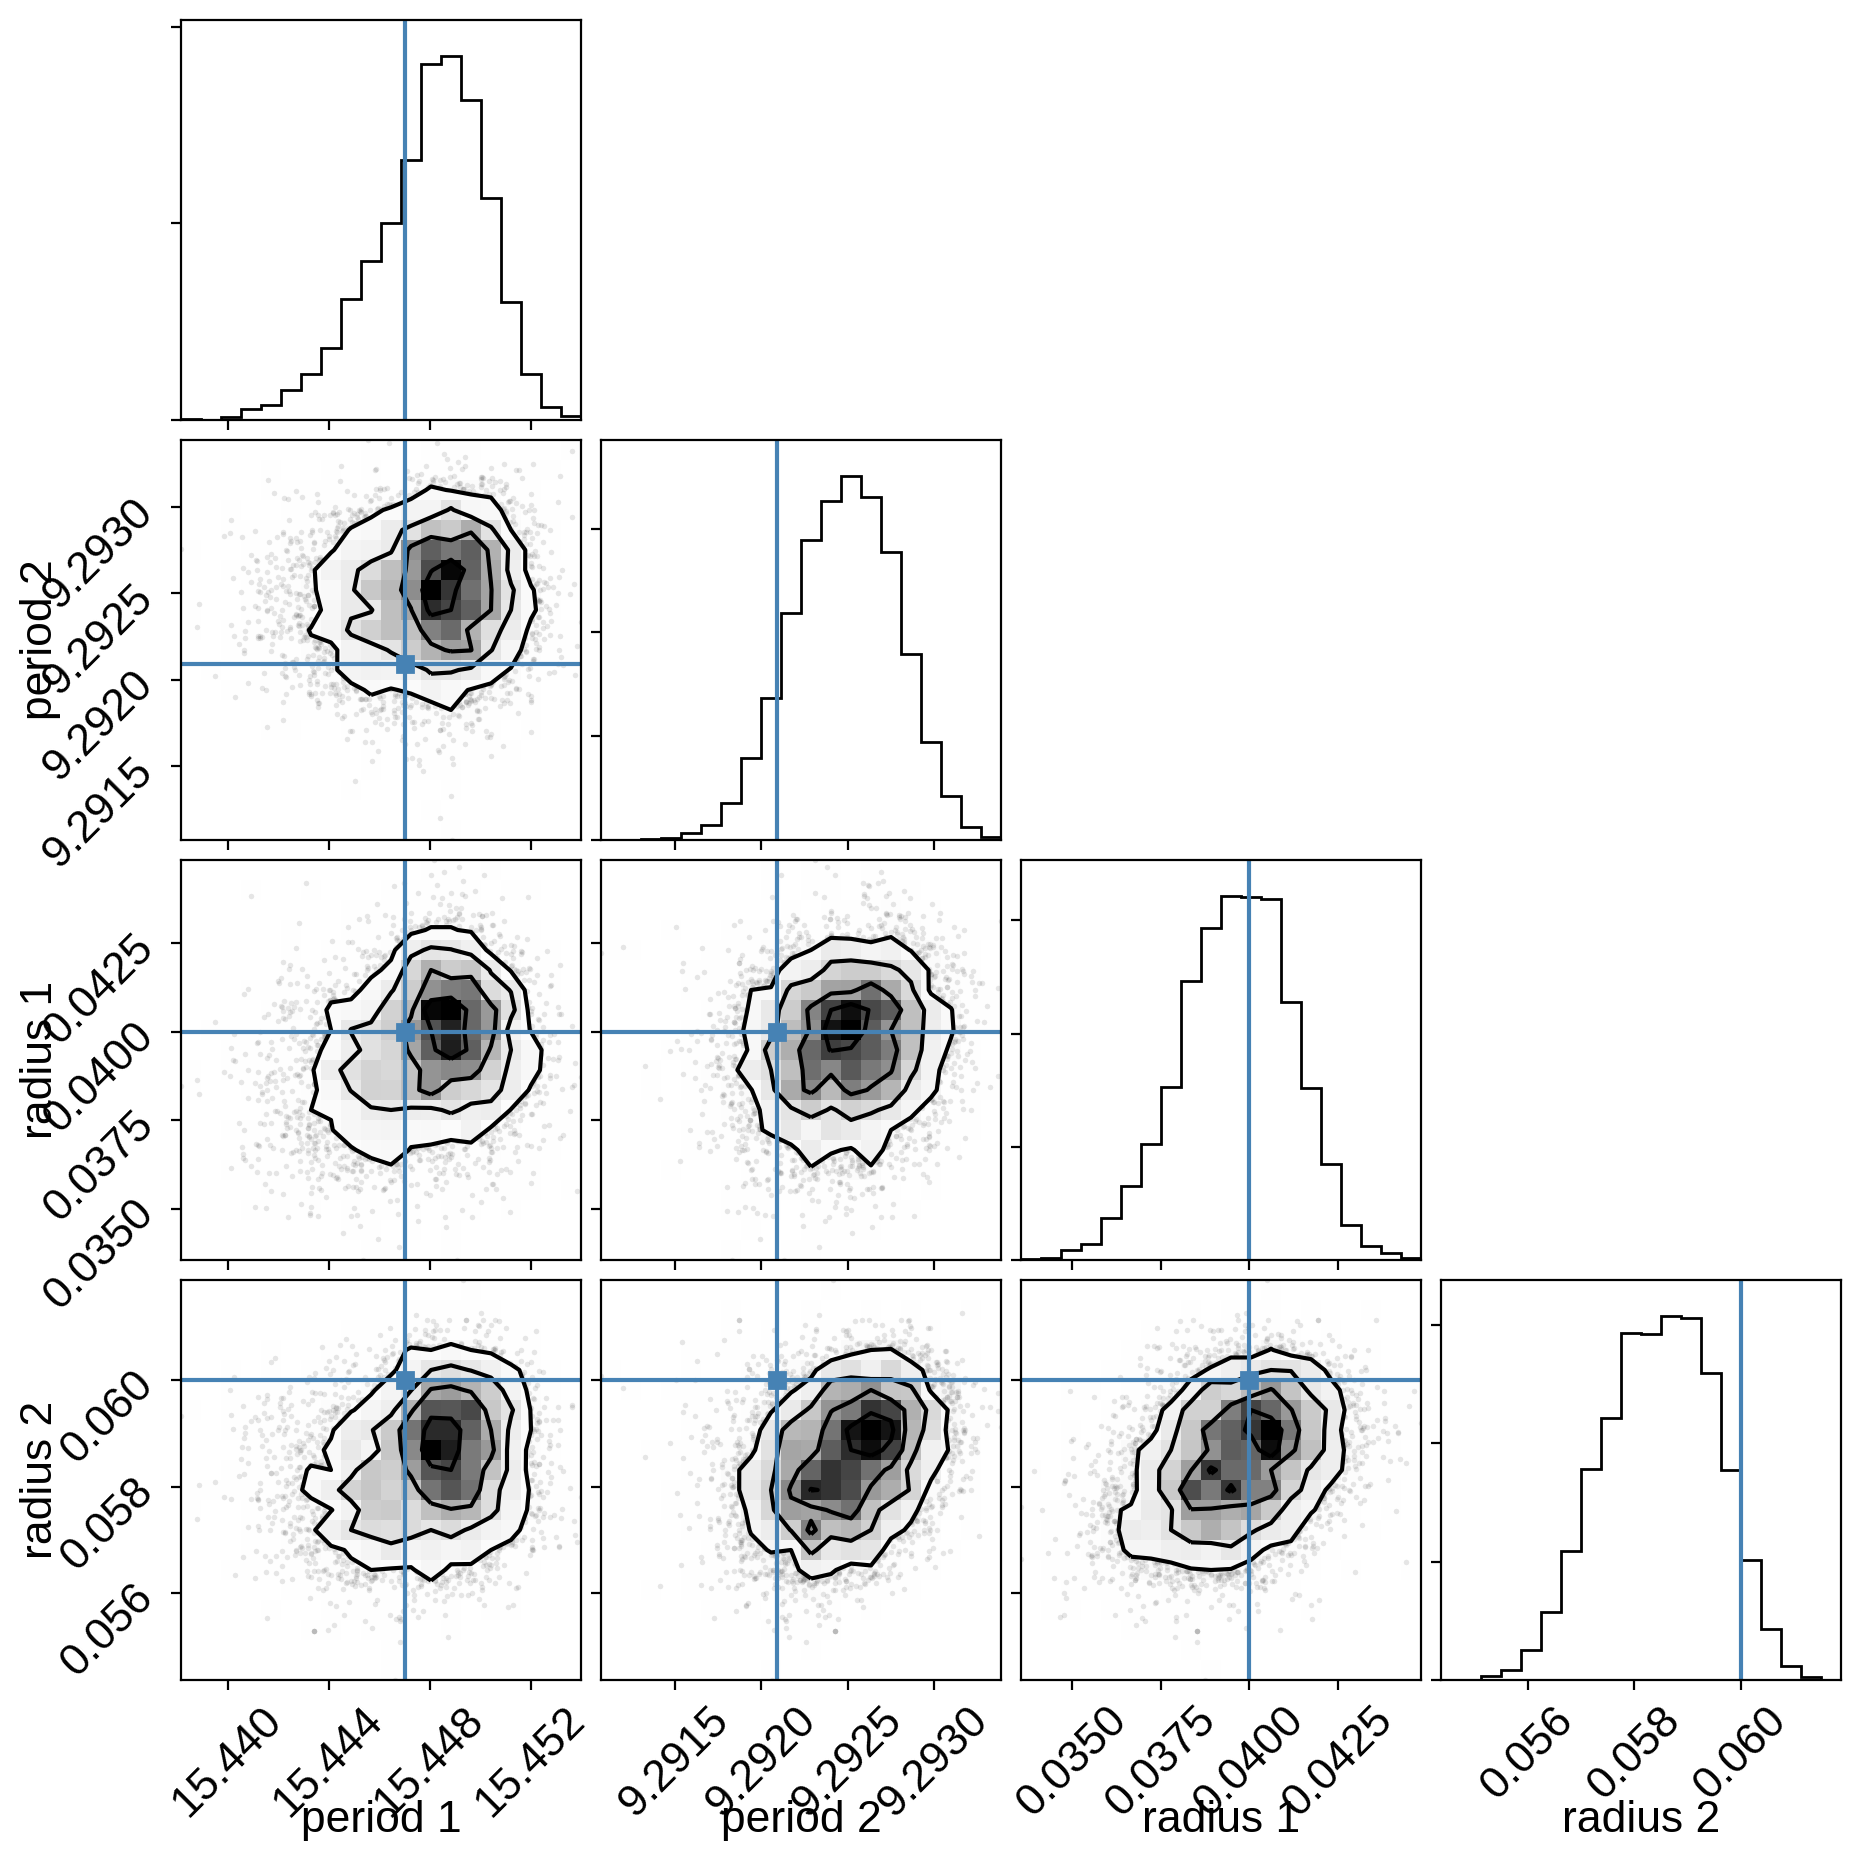

In [9]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["period", "r"])
truth = np.concatenate(
    xo.eval_in_model([period, r], model.test_point, model=model)
)
_ = corner.corner(
    samples,
    truths=truth,
    labels=["period 1", "period 2", "radius 1", "radius 2"],
)

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

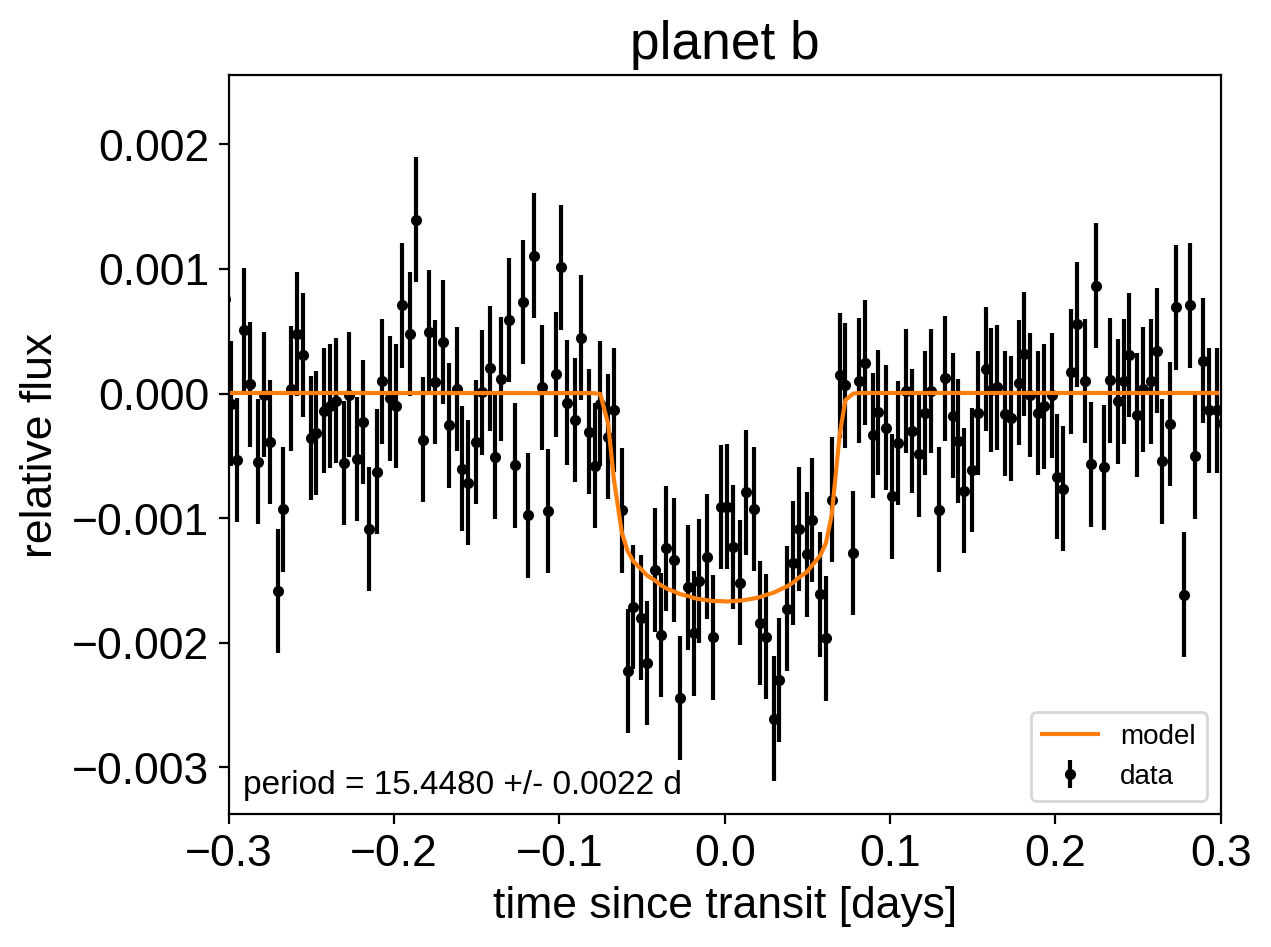

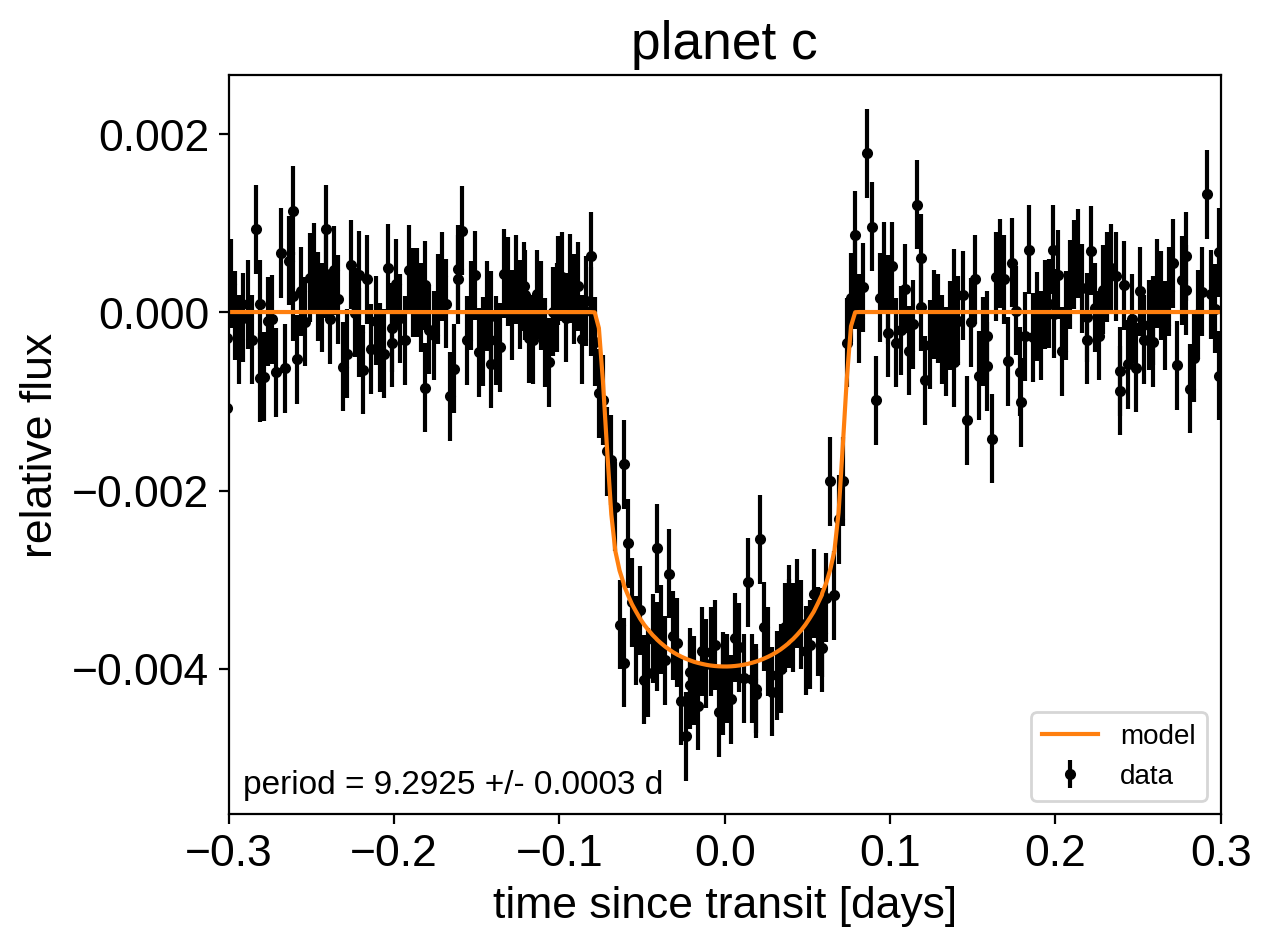

In [10]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000
    )

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.median(pred, axis=0)
    plt.plot(x_fold[inds], pred, color="C1", label="model")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n])
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [11]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


In [12]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.2.5},
   month = mar,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
